<a href="https://colab.research.google.com/github/deagwon97/algorithm/blob/master/notebook/preprocess/%5BHK%5Dpreprocess_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is preprocessing the dataset for hakeing kidney competition.  
I referenced Iafoss's notebook.   
[https://www.kaggle.com/iafoss/256x256-images]  

# Library Import

In [ ]:
from PIL import Image
import tifffile as tiff
import subprocess
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt

import numpy as np
import cv2
import os
from tqdm.notebook import tqdm
import zipfile
import gc
import random


import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from IPython.display import clear_output

train_meta = pd.read_csv('/content/drive/MyDrive/kaggledrive/kidney/new_data/train.csv').set_index('id')
dataset_information = pd.read_csv('/content/drive/MyDrive/kaggledrive/kidney/data/HuBMAP-20-dataset_information.csv')

seed = 1015
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#functions to convert encoding to mask and mask to encoding
def enc2mask(encs, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m,enc in enumerate(encs):
        if isinstance(enc,np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape).T

def mask2enc(mask, shape, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1,n+1):
        p = (pixels == i).astype(np.int8)
        if p.sum() == 0: encs.append(np.nan)
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    return encs

# Load Train data


In [ ]:
# I load data set on google drive before.
# and when I use colab, load the data from the google drive by subprocess.
train_path = "/content/drive/MyDrive/kaggledrive/kidney/new_data/train/"
for idx in train_meta.index:
    subprocess.call(["cp",
                     f"{train_path}{idx}.json",
                     f"{idx}.json"] ,shell = False)
    subprocess.call(["cp",
                     f"{train_path}{idx}-anatomical-structure.json",
                     f"{idx}-anatomical-structure.json"] ,shell = False)
    subprocess.call(["cp",
                    f"{train_path}{idx}.tiff",
                    f"{idx}.tiff"] ,shell = False)

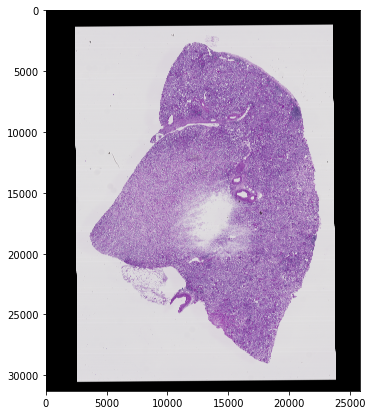

In [ ]:
# sample image of kidney
for idx in train_meta.index:
    plt.figure(figsize = (7,7))
    smaple = tiff.imread(f'{idx}.tiff')
    plt.imshow(smaple)
    plt.show()
    break

# Train data 512,512 crop - tile



Make train data by cutting the original data.

In [ ]:
DATA = ""
sz = 512   #the size of tiles
reduce = 2 #reduce the original images by 2 times 
OUT_TRAIN = 'train_object.zip'
OUT_MASKS = 'masks_object.zip'

s_th = 40  #saturation blancking threshold
p_th = 200*sz//256 #threshold for the minimum number of pixels

x_tot,x2_tot = [],[]
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out, zipfile.ZipFile(OUT_MASKS, 'w') as mask_out:
    for index, encs in tqdm(train_meta.iterrows(),total=len(train_meta)):
        #read image and generate the mask
        img = tiff.imread(os.path.join(DATA,index+'.tiff'))
        if len(img.shape) == 5:img = np.transpose(img.squeeze(), (1,2,0))
        mask = enc2mask(encs,(img.shape[1],img.shape[0]))

        #add padding to make the image dividable into tiles
        shape = img.shape
        pad0 = (reduce*sz - shape[0]%(reduce*sz))%(reduce*sz)
        pad1 = (reduce*sz - shape[1]%(reduce*sz))%(reduce*sz)
        img = np.pad(img,
                     [
                      [pad0//2,pad0-pad0//2],
                      [pad1//2,pad1-pad1//2],
                      [0,0]
                      ],
                     constant_values=0)
        mask = np.pad(mask,
                      [[pad0//2,pad0-pad0//2],
                       [pad1//2,pad1-pad1//2]],
                      constant_values=0)

        #split image and mask into tiles using the reshape+transpose trick
        img = cv2.resize(img,
                         (img.shape[0]//reduce,img.shape[1]//reduce),
                         interpolation = cv2.INTER_AREA)
        img = img.reshape(img.shape[0]//sz,sz,
                          img.shape[1]//sz,sz,
                          3)
        img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)

        mask = cv2.resize(mask,
                          (mask.shape[0]//reduce,mask.shape[1]//reduce),
                          interpolation = cv2.INTER_NEAREST)
        mask = mask.reshape(mask.shape[0]//sz,sz,mask.shape[1]//sz,
                            sz)
        mask = mask.transpose(0,2,1,3).reshape(-1,sz,sz)

        #write data
        for i,(im,m) in enumerate(zip(img,mask)):
            #remove black or gray images based on saturation check
            hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            if (s>s_th).sum() <= p_th or im.sum() <= p_th: continue
            if m.sum() <= 1 : continue
    
            x_tot.append((im/255.0).reshape(-1,3).mean(0))
            x2_tot.append(((im/255.0)**2).reshape(-1,3).mean(0))
            
            im = cv2.imencode('.png',cv2.cvtColor(im, cv2.COLOR_RGB2BGR))[1]
            img_out.writestr(f'{index}_{i}.png', im)

            m = cv2.imencode('.png',m)[1]
            mask_out.writestr(f'{index}_{i}.png', m)

#image stats
img_avr =  np.array(x_tot).mean(0)
img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
print('mean:',img_avr, ', std:', img_std)



mean: [0.61391619 0.4130012  0.66073108] , std: [0.13626192 0.20135201 0.11772804]


## Save croped data on google drive

In [ ]:
path = "/content/drive/MyDrive/kaggledrive/kidney/new_data/"
!cp train_object.zip "{path}train_object_512.zip"
!cp masks_object.zip "{path}masks_object_512.zip"

# Train data 512,512 crop - slide

Make 4 times more samples by sliding the original data.

In [ ]:
DATA = ""
sz = 512   #the size of tiles
reduce = 2 #reduce the original images by 2 times 
OUT_TRAIN = 'train_object.zip'
OUT_MASKS = 'masks_object.zip'

s_th = 40  #saturation blancking threshold
p_th = 200*sz//256 #threshold for the minimum number of pixels

x_tot,x2_tot = [],[]
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out, zipfile.ZipFile(OUT_MASKS, 'w') as mask_out:
    for index, encs in train_meta.iterrows():
        #read image and generate the mask
        img = tiff.imread(os.path.join(DATA,index+'.tiff'))
        if len(img.shape) == 5:img = np.transpose(img.squeeze(), (1,2,0))
        mask = enc2mask(encs,(img.shape[1],img.shape[0]))

        #add padding to make the image dividable into tiles
        shape = img.shape

        x_length = shape[0] // 512
        y_length = shape[1] // 512

        #write data
        i = 0
        for x in tqdm(range(x_length + 1)):
            for y in range(y_length + 1):

                if x == x_length:
                    x_start = -1024
                    x_end   = None
                else:
                    x_start = 512 * x
                    x_end   = x_start + 1024

                if y == y_length:
                    y_start = -1024
                    y_end   = None
                else:
                    y_start = 512 * y
                    y_end   = y_start + 1024

                im =  img[x_start:x_end, y_start:y_end,:]
                m  = mask[x_start:x_end, y_start:y_end]

                #remove black or gray images based on saturation check
                hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
                h, s, v = cv2.split(hsv)
                if (s>s_th).sum() <= p_th or im.sum() <= p_th: continue
                if m.sum() <= 1 : continue
        
                x_tot.append((im/255.0).reshape(-1,3).mean(0))
                x2_tot.append(((im/255.0)**2).reshape(-1,3).mean(0))
                
                im = cv2.resize(im,(sz, sz),interpolation = cv2.INTER_AREA)
                im = cv2.imencode('.png',cv2.cvtColor(im, cv2.COLOR_RGB2BGR))[1]
                img_out.writestr(f'{index}_{i}.png', im)

                m = cv2.resize(m,(sz, sz),interpolation = cv2.INTER_NEAREST)
                m = cv2.imencode('.png',m)[1]
                mask_out.writestr(f'{index}_{i}.png', m)
                i +=1

#image stats
img_avr =  np.array(x_tot).mean(0)
img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
print('mean:',img_avr, ', std:', img_std)



mean: [0.61465579 0.41331789 0.66119966] , std: [0.1401509  0.2051208  0.12020434]


## Save croped data on google drive

In [ ]:
path = "/content/drive/MyDrive/kaggledrive/kidney/slide_data/"
!cp train_object.zip "{path}train_object_512.zip"
!cp masks_object.zip "{path}masks_object_512.zip"

# Show data

Code to check the samples.

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


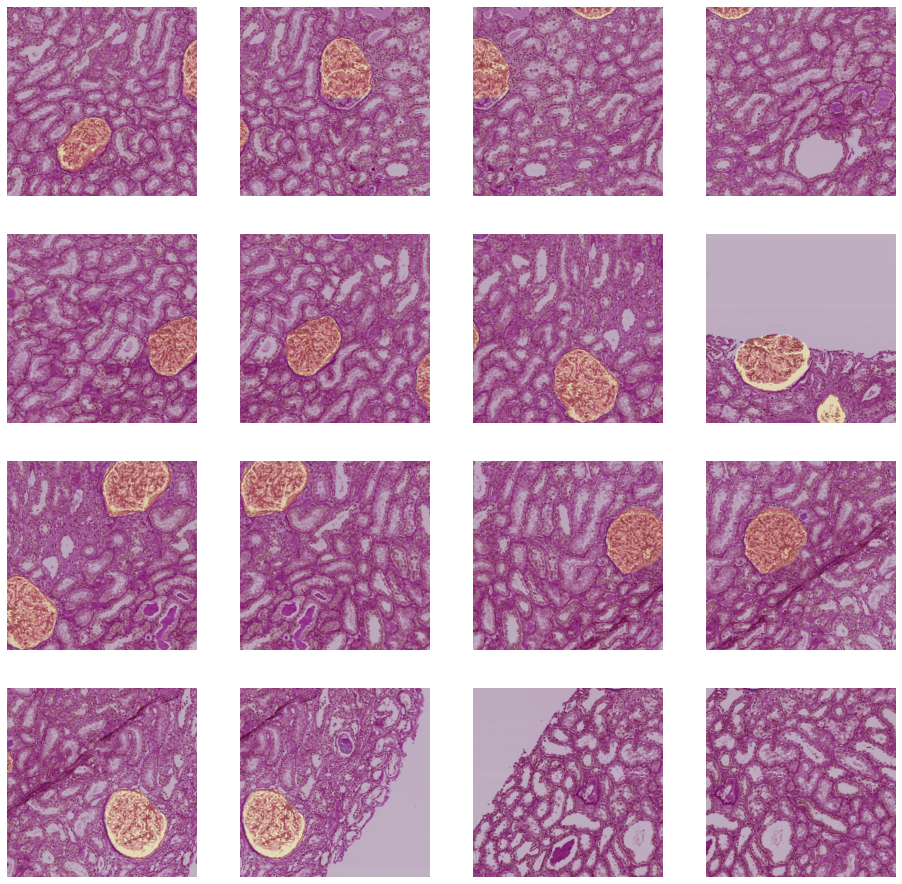

In [ ]:
columns, rows = 4,4
idx0 = 20
fig=plt.figure(figsize=(columns*4, rows*4))
with zipfile.ZipFile(OUT_TRAIN, 'r') as img_arch, \
     zipfile.ZipFile(OUT_MASKS, 'r') as msk_arch:
    fnames = sorted(img_arch.namelist())[8:]
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            flags = cv2.IMREAD_COLOR 
            img = cv2.imdecode(np.frombuffer(img_arch.read(fnames[idx0+idx]),
                                             np.uint8),
                                flags)
            print(img.shape)
            flags = cv2.IMREAD_GRAYSCALE
            mask = cv2.imdecode(np.frombuffer(msk_arch.read(fnames[idx0+idx]),
                                              np.uint8),
                                 flags)
    
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow(Image.fromarray(img))
            plt.imshow(Image.fromarray(mask), alpha=0.2)
plt.show()